In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Aggregate transaction data at the customer level
customer_transaction_data = transactions.groupby("CustomerID").agg({
    "TotalValue": "sum",  # Total spending
    "Quantity": "sum"     # Total quantity purchased
}).reset_index()

# Merge with customer profile data
customer_data = pd.merge(customers, customer_transaction_data, on="CustomerID", how="inner")

# Display merged data
print(customer_data.head())


  CustomerID        CustomerName         Region  SignupDate  TotalValue  \
0      C0001    Lawrence Carroll  South America  2022-07-10     3354.52   
1      C0002      Elizabeth Lutz           Asia  2022-02-13     1862.74   
2      C0003      Michael Rivera  South America  2024-03-07     2725.38   
3      C0004  Kathleen Rodriguez  South America  2022-10-09     5354.88   
4      C0005         Laura Weber           Asia  2022-08-15     2034.24   

   Quantity  
0        12  
1        10  
2        14  
3        23  
4         7  


In [5]:
from sklearn.preprocessing import StandardScaler

# Select numerical features for clustering
features = ["TotalValue", "Quantity"]
data_for_clustering = customer_data[features]

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Convert back to DataFrame for easier visualization
scaled_df = pd.DataFrame(scaled_data, columns=features)
print(scaled_df.head())


   TotalValue  Quantity
0   -0.061701 -0.122033
1   -0.877744 -0.448000
2   -0.405857  0.203934
3    1.032547  1.670787
4   -0.783929 -0.936951


In [10]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")


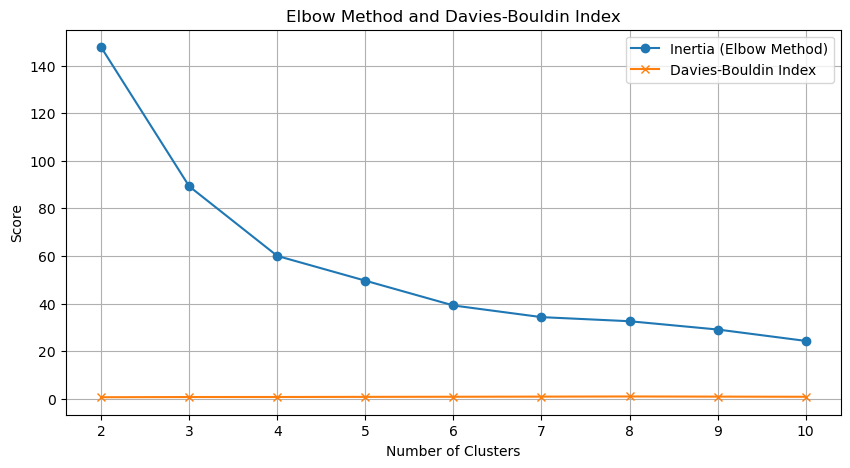

In [11]:
# Set the environment variable to avoid warnings
import os
os.environ["OMP_NUM_THREADS"] = "1"

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt

# Use Elbow Method and DB Index to determine optimal clusters
inertia = []
db_scores = []

for k in range(2, 11):  # Trying clusters from 2 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)
    db_scores.append(davies_bouldin_score(scaled_data, kmeans.labels_))

# Plot Elbow Curve and DB Index
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), inertia, marker="o", label="Inertia (Elbow Method)")
plt.plot(range(2, 11), db_scores, marker="x", label="Davies-Bouldin Index")
plt.title("Elbow Method and Davies-Bouldin Index")
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()


In [12]:
# Apply KMeans clustering with the optimal number of clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_data["Cluster"] = kmeans.fit_predict(scaled_data)

# Display clustering results
print(customer_data[["CustomerID", "Cluster"]].head())


  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        3


In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Define the optimal number of clusters (replace 'optimal_clusters' with your result from the elbow method/DB Index analysis)
optimal_clusters = 4  # Example: Replace with the value you determined
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(scaled_data)

# Calculate DB Index
db_index = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f"Davies-Bouldin Index for {optimal_clusters} clusters: {db_index}")


Davies-Bouldin Index for 4 clusters: 0.7212797181816302


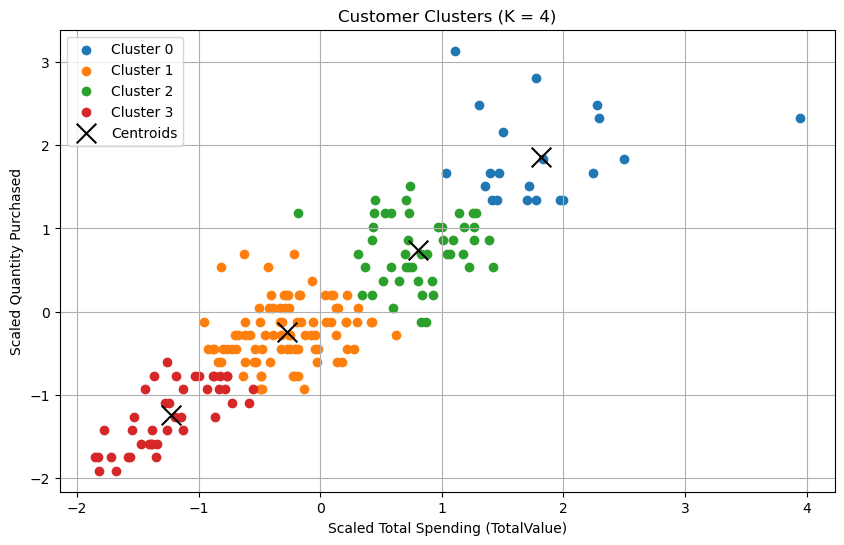

In [16]:
# Scatter plot for clusters based on scaled data
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    plt.scatter(
        scaled_data[kmeans.labels_ == cluster, 0],
        scaled_data[kmeans.labels_ == cluster, 1],
        label=f"Cluster {cluster}"
    )
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    color="black",
    marker="x",
    s=200,
    label="Centroids"
)
plt.title(f"Customer Clusters (K = {optimal_k})")
plt.xlabel("Scaled Total Spending (TotalValue)")
plt.ylabel("Scaled Quantity Purchased")
plt.legend()
plt.grid(True)
plt.show()


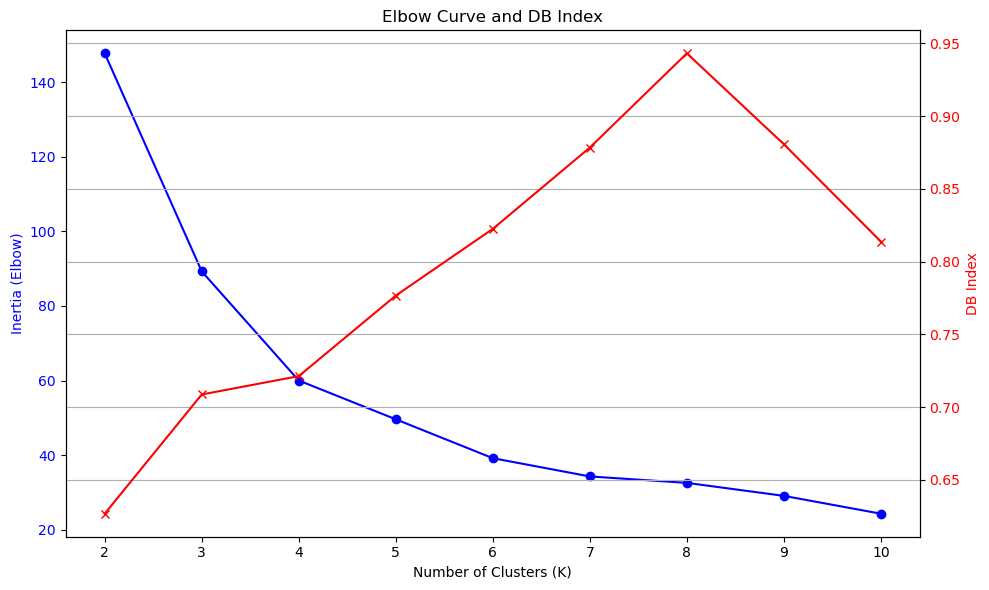

In [17]:
# Create a figure for both plots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Elbow Curve
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Inertia (Elbow)", color="blue")
ax1.plot(range(2, 11), inertia, marker="o", label="Inertia", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_title("Elbow Curve and DB Index")

# Add DB Index on the same plot
ax2 = ax1.twinx()
ax2.set_ylabel("DB Index", color="red")
ax2.plot(range(2, 11), db_scores, marker="x", label="DB Index", color="red")
ax2.tick_params(axis="y", labelcolor="red")

fig.tight_layout()
plt.grid(True)
plt.show()


C:\Users\pooja\AppData\Local\Temp\ipykernel_17004\1955847879.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")


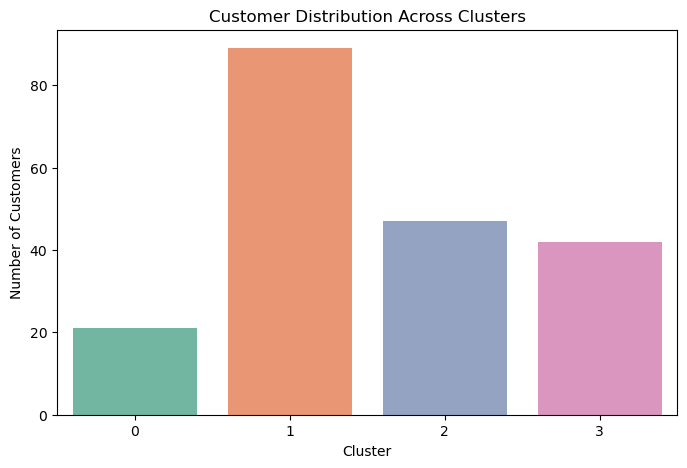

In [18]:
# Count the number of customers in each cluster
cluster_counts = customer_data["Cluster"].value_counts()

# Plot a bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette="Set2")
plt.title("Customer Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.xticks(rotation=0)
plt.show()
